# Introducing the Permutational Invariant Quantum Solver (PIQS)

The *Permutational Invariant Quantum Solver (PIQS)* is an open-source Python solver to study the exact Lindbladian dynamics of open quantum systems consisting of identical qubits. It is integrated in QuTiP and can be imported as as a model.

Using this library, the Liouvillian of an ensemble of $N$ qubits, or two-level systems (TLSs), $\mathcal{D}_{TLS}(\rho)$, can be built using only polynomial – instead of exponential – resources. This has many applications for the study of realistic quantum optics models of many TLSs and in general as a tool in cavity QED [1].

Consider a system evolving according to the equation

\begin{eqnarray}
\dot{\rho} = \mathcal{D}_\text{TLS}(\rho) &=& 
-\frac{i}{\hbar}\lbrack H,\rho \rbrack
+\frac{\gamma_\text{CE}}{2}\mathcal{L}_{J_{-}}[\rho]
+\frac{\gamma_\text{CD}}{2}\mathcal{L}_{J_{z}}[\rho]
+\frac{\gamma_\text{CP}}{2}\mathcal{L}_{J_{+}}[\rho]\nonumber\\
&&+\sum_{n=1}^{N}\left(
\frac{\gamma_\text{E}}{2}\mathcal{L}_{J_{-,n}}[\rho]
+\frac{\gamma_\text{D}}{2}\mathcal{L}_{J_{z,n}}[\rho]
+\frac{\gamma_\text{P}}{2}\mathcal{L}_{J_{+,n}}[\rho]\right)
\end{eqnarray}

where $J_{\alpha,n}=\frac{1}{2}\sigma_{\alpha,n}$ are SU(2) Pauli spin operators, with ${\alpha=x,y,z}$ and $J_{\pm,n}=\sigma_{\pm,n}$. The collective spin operators are $J_{\alpha} = \sum_{n}J_{\alpha,n}$. The Lindblad super-operators are $\mathcal{L}_{A} = 2A\rho A^\dagger - A^\dagger A \rho - \rho A^\dagger A$.

The inclusion of local processes in the dynamics lead to using a Liouvillian space of dimension $4^N$. By exploiting the permutational invariance of identical particles [2-8], the Liouvillian $\mathcal{D}_\text{TLS}(\rho)$ can be built as a block-diagonal matrix in the basis of Dicke states $|j, m \rangle$.

The system under study is defined by creating an object of the $\texttt{Piqs}$ class, e.g. simply named $\texttt{system}$, whose first attribute is 

- $\texttt{system.N}$, the number of TLSs of the system $N$.

The rates for collective and local processes are simply defined as 

- $\texttt{collective}\_ \texttt{emission}$ defines $\gamma_\text{CE}$, collective (superradiant) emission


- $\texttt{collective}\_ \texttt{dephasing}$ defines $\gamma_\text{CD}$, collective dephasing 


- $\texttt{collective}\_ \texttt{pumping}$ defines $\gamma_\text{CP}$, collective pumping. 


- $\texttt{emission}$ defines $\gamma_\text{E}$, incoherent emission (losses) 


- $\texttt{dephasing}$ defines $\gamma_\text{D}$, local dephasing 


- $\texttt{pumping}$  defines $\gamma_\text{P}$, incoherent pumping. 

Then the $\texttt{system.lindbladian()}$ creates the total TLS Linbladian superoperator matrix.

Similarly, $\texttt{system.hamiltonian}$ defines the TLS hamiltonian of the system $H_\text{TLS}$.

The system's Liouvillian can be built using $\texttt{system.liouvillian()}$. The properties of a Piqs object can be visualized by simply calling $\texttt{system}$. 

We give two basic examples on the use of *PIQS*. In the first example the incoherent emission of $N$ driven TLSs is considered.

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm

from qutip import *
from piqs import *
from piqs.cy.dicke import j_min

## $1$. $N$ Qubits Dynamics
We study a driven ensemble of $N$ TLSs emitting incoherently,

\begin{eqnarray}
H_\text{TLS}&=&\hbar\omega_{0} J_{z}+\hbar\omega_{x} J_{x}
\end{eqnarray}

\begin{eqnarray}
\dot{\rho} &=& \mathcal{D}_\text{TLS}(\rho)= -\frac{i}{\hbar}\lbrack H_\text{TLS},\rho \rbrack+\sum_{n=1}^{N}\frac{\gamma_\text{E}}{2}\mathcal{L}_{J_{-,n}}[\rho]
\end{eqnarray}

In [2]:
N = 20
system = Dicke(N = N)
[jx, jy, jz, jp, jm] = j_algebra(N)
w0 = 1.
wx = 0.1
system.hamiltonian = w0 * jz + wx * jx
system.emission = 0.5
D_tls = system.liouvillian() 

Calculating the TLS Steady state and steady expectation values is straightforward with QuTiP's $\texttt{steadystate}()$ and $\texttt{expect}()$ [9]. 

In [3]:
steady_tls = steadystate(D_tls)
jz_ss = expect(jz, steady_tls)
jpjm_ss = expect(jp*jm, steady_tls)

Calculating the TLS time evolution can be done with QuTiP's $\texttt{mesolve}()$

In [4]:
rho0_tls = dicke(N, N/2, -N/2)
t = np.linspace(0, 20, 1000)
result = mesolve(D_tls, rho0_tls, t, [], e_ops = [jz])
rhot_tls = result.states
jzt = result.expect[0]

The properties of a given object can be updated dynamically, such that local dephasing could be added to the object $\texttt{'system'}$ symply with 

In [5]:
system.dephasing = 1

### Visualization

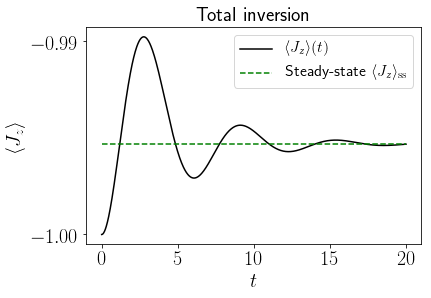

In [6]:
j_max = (N/2)
label_size = 20

fig1 = plt.figure(1)

plt.rc('text', usetex = True)
plt.rc('xtick', labelsize=label_size) 
plt.rc('ytick', labelsize=label_size)
plt.plot(t, jzt/j_max, 'k-', label=r'$\langle J_{z}\rangle(t)$')
plt.plot(t, t * 0 + jz_ss/j_max, 'g--', label = R'Steady-state $\langle J_{z}\rangle_\mathrm{ss}$')
plt.title(r'Total inversion', fontsize = label_size)
plt.xlabel(r'$t$', fontsize = label_size)
plt.ylabel(r'$\langle J_{z}\rangle$', fontsize = label_size)
plt.legend( fontsize = 0.8 * label_size)
plt.yticks([-1, -0.99])
plt.show()
plt.close()

## $2$. Dynamics of $N$ Qubits in a Bosonic Cavity 

Now we consider an ensemble of spins in a driven, leaky cavity

\begin{eqnarray}
\dot{\rho} &=& \mathcal{D}_\text{TLS}(\rho) +\mathcal{D}_\text{phot}(\rho) -\frac{i}{\hbar}\lbrack H_\text{int}, \rho\rbrack\nonumber\\
&=& -i\lbrack \omega_{0} J_{z} + \omega_{c} a^\dagger a + g\left(a^\dagger+a\right)J_{x},\rho \rbrack+\frac{w}{2}\mathcal{L}_{a^\dagger}[\rho]+\frac{\kappa}{2}\mathcal{L}_{a}[\rho]+\sum_{n=1}^{N}\frac{\gamma_\text{E}}{2}\mathcal{L}_{J_{-,n}}[\rho]
\end{eqnarray}

where now the full system density matrix is defined on a tensor Hilbert space $\rho \in \mathcal{H}_\text{TLS}\otimes\mathcal{H}_\text{phot}$, where the dymension of $\mathcal{H}_\text{TLS}$ is reduced from $2^N$ using the approach of an uncoupled basis to $O(N^2)$ using $PIQS$.

Thanks to QuTiP's $\texttt{super}\_\texttt{tensor}()$ function, we can add the two independently built Liouvillians, being careful only to place the light-matter interaction of the Hamiltonian in the total Hilbert space and creating the corresponding "left" and "right" superoperators with $\texttt{spre}()$ and $\texttt{spost}()$.

In [7]:
# TLS parameters
n_tls = 5
N = n_tls
system = Dicke(N = n_tls)
[jx, jy, jz, jp, jm] = j_algebra(n_tls)
w0 = 1.
wx = 0.1
system.hamiltonian = w0 * jz + wx * jx
system.emission = 0.5
D_tls = system.liouvillian() 

# Light-matter coupling parameters
wc = 1.
g = 0.9
kappa = 1
pump = 0.1
nphot = 16
a = destroy(nphot)
h_int = g * tensor(a + a.dag(), jx)

# Photonic Liouvillian
c_ops_phot = [np.sqrt(kappa) * a, np.sqrt(pump) * a.dag()]
D_phot = liouvillian(wc * a.dag()*a , c_ops_phot)

# Identity super-operators
nds = num_dicke_states(n_tls)
id_tls = to_super(qeye(nds))
id_phot = to_super(qeye(nphot))

# Define the total Liouvillian
D_int = -1j* spre(h_int) + 1j* spost(h_int)
D_tot = D_int + super_tensor(D_phot, id_tls) + super_tensor(id_phot, D_tls)

# Define operator in the total space
nphot_tot = tensor(a.dag()*a, qeye(nds))

### Wigner function and steady state $\rho_\text{ss}$

In [8]:
rho_ss = steadystate(D_tot)
nphot_ss = expect(nphot_tot, rho_ss)
psi = rho_ss.ptrace(0)
xvec = np.linspace(-6, 6, 100)
W = wigner(psi, xvec, xvec)

### Visualization

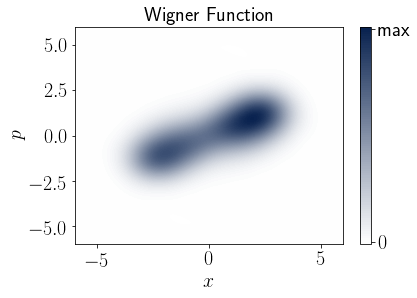

In [9]:
jmax = (0.5 * N)
j2max = (0.5 * N + 1) * (0.5 * N)

plt.rc('text', usetex = True)
label_size = 20
plt.rc('xtick', labelsize=label_size) 
plt.rc('ytick', labelsize=label_size)

wmap = wigner_cmap(W)  # Generate Wigner colormap
nrm = mpl.colors.Normalize(0, W.max())
max_cb =np.max(W)
min_cb =np.min(W)

fig2 = plt.figure(2)
plotw = plt.contourf(xvec, xvec, W, 100, cmap=wmap, norm=nrm)

plt.title(r"Wigner Function", fontsize=label_size);
plt.xlabel(r'$x$', fontsize = label_size)
plt.ylabel(r'$p$', fontsize = label_size)
cb = plt.colorbar()
cb.set_ticks( [min_cb, max_cb])
cb.set_ticklabels([r'$0$',r'max'])    

plt.show()
plt.close()

### Time evolution of $\rho(t)$

In [10]:
excited_state = excited(N)
ground_phot = ket2dm(basis(nphot,0))
rho0 = tensor(ground_phot, excited_state)
result2 = mesolve(D_tot, rho0, t, [], e_ops = [nphot_tot])
rhot_tot = result2.states
nphot_t = result2.expect[0]

### Visualization

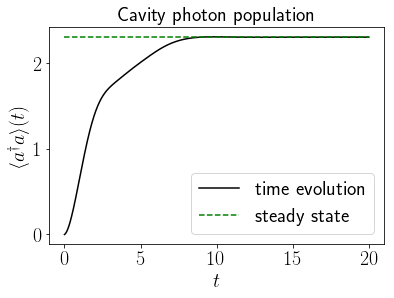

In [11]:
fig3 = plt.figure(3)
plt.plot(t, nphot_t, 'k-', label='time evolution')
plt.plot(t, t*0 + nphot_ss, 'g--', label = 'steady state')
plt.title(r'Cavity photon population', fontsize = label_size)
plt.xlabel(r'$t$', fontsize = label_size)
plt.ylabel(r'$\langle a^\dagger a\rangle(t)$', fontsize = label_size)

plt.legend(fontsize = label_size)
plt.show()
plt.close()

 ### Steady-state correlations: $g^{(2)}(\tau)$ for $\rho_\text{ss}$
We define the $g^{(2)}(\tau)$ of the system as the two-time correlation function of the intracavity photons,
\begin{eqnarray}
g^{(2)}(\tau) &=& \frac{\langle: a^\dagger(\tau) a^\dagger(0) a(\tau) a(0) :\rangle}{|\langle: a^\dagger(0) a(0) :\rangle|^2}\nonumber.
\end{eqnarray}

In [12]:
B = nphot_tot
rhoA = B * rho_ss
result3 = mesolve(D_tot, rhoA, t, [], e_ops = B)
g2_t = result3.expect[0]

### Visualization

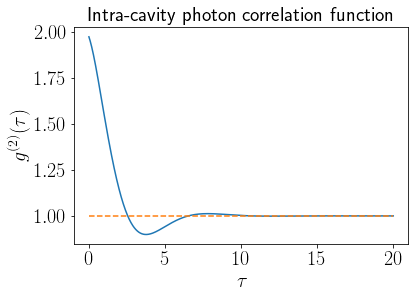

In [13]:
fig4 = plt.figure(4)
plt.plot(t, np.real(g2_t)/nphot_ss**2, '-')
plt.plot(t, 0*t + 1, '--')
plt.title(r'Intra-cavity photon correlation function', fontsize = label_size)
plt.xlabel(r'$\tau$', fontsize = label_size)
plt.ylabel(r'$g^{(2)}(\tau)$', fontsize = label_size)

plt.show()
plt.close()

## $3$. Initial States

$PIQS$ allows the user to quickly define initial states as density matrices in the Dicke basis of dimension $O(N^2)$ (by default) or in the uncoupled TLS basis $2^N$ (by setting the basis specification as $\texttt{basis='uncoupled'}$). Below we give an overview of

- Dicke states with "$\texttt{dicke}()$",


- Greenberger–Horne–Zeilinger (GHZ), called by "$\texttt{ghz}()$",


- Coherent Spin States (CSS) called by "$\texttt{css}()$",

hereafter all expressed in the compact Dicke basis.

In [14]:
N = 6
#Dicke Basis
dicke_basis = np.real(block_matrix(N))
#Dicke states
excited_state = dicke(N, N/2, N/2)
superradiant_state = dicke(N, N/2, j_min(N))
subradiant_state = dicke(N, j_min(N), -j_min(N))
ground_state = dicke(N, N/2, -N/2)

N = 7
#GHZ state
ghz_state = ghz(N)
#CSS states
a = 1/np.sqrt(2)
b = 1/np.sqrt(2)
css_symmetric = css(N, a, b)
css_antisymmetric = css(N, a, -b)

### Visualization

In [15]:
label_size = 15
c_map = 'bwr'

# Convert to real-valued dense matrices
rho1 = np.real(css_antisymmetric.full())
rho3b = np.real(ghz_state.full())         
rho4b = np.real(css_symmetric.full())
rho5 = np.real(excited_state.full())
rho6 = np.real(superradiant_state.full())
rho7 = np.real(ground_state.full())
rho8 = np.real(subradiant_state.full())
rho9 = np.real(dicke_basis.todense())

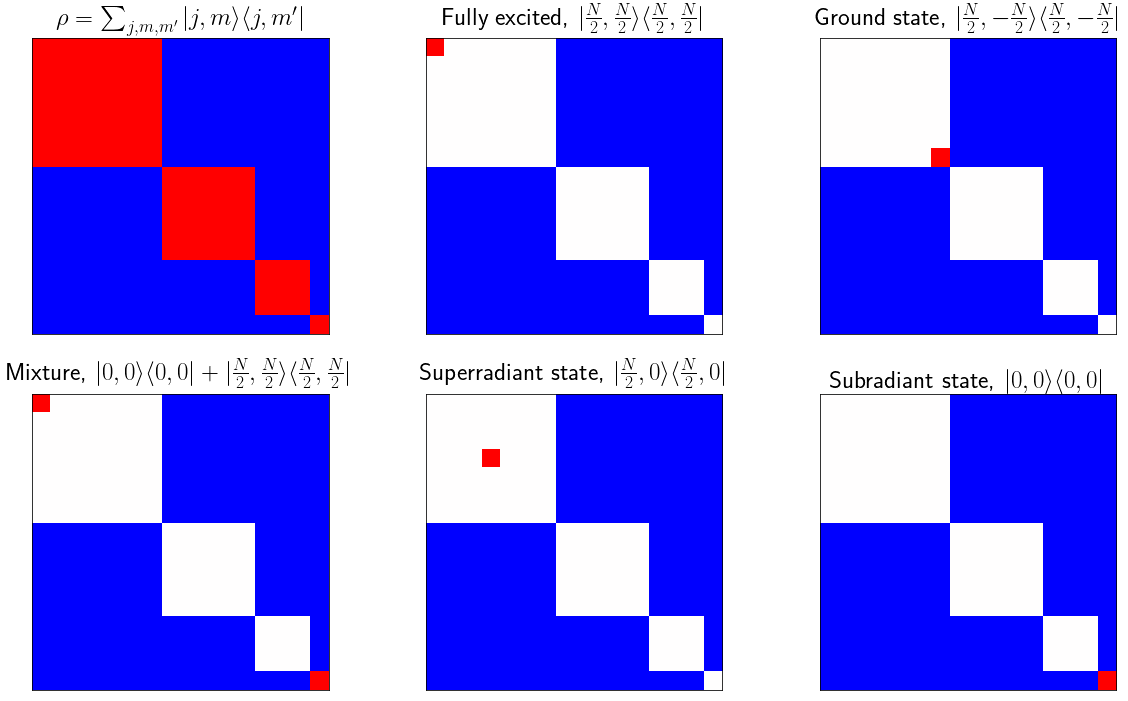

In [16]:
# Dicke basis
plt.rc('text', usetex = True)
label_size = 25
plt.rc('xtick', labelsize=label_size) 
plt.rc('ytick', labelsize=label_size)

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 12))
fig1 = axes[0,0].imshow(rho9, cmap = c_map)
axes[0,0].set_title(r"$\rho=\sum_{j,m,m'}|j,m\rangle\langle j,m'|$",
          fontsize = label_size)
plt.setp(axes, xticks=[],
        yticks=[])
#Excited
fig2 = axes[0,1].imshow(rho9+rho5, cmap = c_map)    
axes[0,1].set_title(r"Fully excited, $|\frac{N}{2},\frac{N}{2}\rangle\langle \frac{N}{2},\frac{N}{2}|$", fontsize = label_size)
#Ground
fig3 = axes[0,2].imshow(rho9+rho7, cmap = c_map)    
axes[0,2].set_title(r"Ground state, $|\frac{N}{2},-\frac{N}{2}\rangle\langle \frac{N}{2},-\frac{N}{2}|$", fontsize = label_size)
#Classical Mixture
fig4 = axes[1,0].imshow(rho9+(rho8+rho5), cmap = c_map)    
axes[1,0].set_title(r"Mixture, $|0,0\rangle\langle 0,0|+|\frac{N}{2},\frac{N}{2}\rangle\langle \frac{N}{2},\frac{N}{2}|$", fontsize = label_size)
#Superradiant
fig5 = axes[1,1].imshow(rho9+rho6, cmap = c_map)    
axes[1,1].set_title(r"Superradiant state, $|\frac{N}{2},0\rangle\langle \frac{N}{2},0|$", fontsize = label_size)
#Subradiant
fig6 = axes[1,2].imshow(rho9+rho8, cmap = c_map)    
axes[1,2].set_title(r"Subradiant state, $|0,0\rangle\langle 0,0|$", fontsize = label_size)

plt.show()
plt.close()



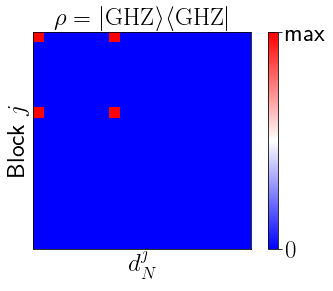

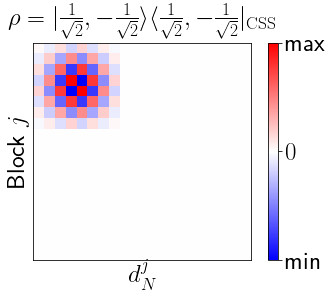

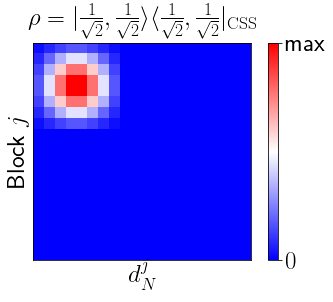

In [17]:
# GHZ state
fig3 = plt.imshow(rho3b, cmap = c_map)

plt.rc('xtick', labelsize=label_size) 
plt.rc('ytick', labelsize=label_size)

plt.title(r'$\rho=|\mathrm{GHZ}\rangle\langle\mathrm{GHZ}|$', fontsize = label_size)
plt.xticks([])
plt.yticks([])
plt.xlabel(r'$d_N^j$', fontsize = label_size)
plt.ylabel(r'Block $j$', fontsize = label_size)

cb = plt.colorbar()
plt.clim([0,np.max(rho3b)])
cb.set_ticks( [np.min(rho3b), np.max(rho3b)])
cb.set_ticklabels([r'$0$',r'max'])    

plt.show()
plt.close()    

#Symmetric CSS state
fig1 = plt.imshow(rho1, cmap = c_map)

plt.rc('text', usetex = True)
plt.rc('xtick', labelsize=label_size) 
plt.rc('ytick', labelsize=label_size)

plt.title(r'$\rho=|\frac{1}{\sqrt{2}},-\frac{1}{\sqrt{2}}\rangle\langle\frac{1}{\sqrt{2}},-\frac{1}{\sqrt{2}}|_\mathrm{CSS}$', fontsize = label_size)
plt.xticks([])
plt.yticks([])
plt.xlabel(r'$d_N^j$', fontsize = label_size)
plt.ylabel(r'Block $j$', fontsize = label_size)

cb = plt.colorbar()
plt.clim([np.min(rho1),np.max(rho1)])
cb.set_ticks( [np.min(rho1),0, np.max(rho1)])
cb.set_ticklabels([r'min',r'$0$',r'max'])

plt.show()
plt.close()

#Antisymmetric CSS state

fig5 = plt.imshow(rho4b, cmap = c_map)

cb = plt.colorbar()
plt.clim([0,np.max(rho4b)])
cb.set_ticks( [0, np.max(rho4b)])
cb.set_ticklabels([r'$0$',r'max'])   

plt.rc('xtick', labelsize=label_size) 
plt.rc('ytick', labelsize=label_size)

plt.title(r'$\rho=|\frac{1}{\sqrt{2}},\frac{1}{\sqrt{2}}\rangle\langle\frac{1}{\sqrt{2}},\frac{1}{\sqrt{2}}|_\mathrm{CSS}$', fontsize = label_size)
plt.xticks([])
plt.yticks([])

plt.xlabel(r'$d_N^j$', fontsize = label_size)
plt.ylabel(r'Block $j$', fontsize = label_size)

plt.show()
plt.close()

## References

[1] B.A. Chase and J.M. Geremia, *Phys Rev. A* **78**, 052101 (2008)

[2] M. Xu, D.A. Tieri, and M.J. Holland, *Phys Rev. A* **87**, 062101 (2013)

[3] S. Hartmann, *Quantum Inf. Comput.* **16**, 1333 (2016)

[4] F. Damanet, D. Braun, and J. Martin, *Phys. Rev. A* **94**, 033838 (2016)

[5] P. Kirton and J. Keeling, , *Phys. Rev. Lett.* **118**, 123602 (2017) https://github.com/peterkirton/permutations 

[6] N. Shammah, N. Lambert, F. Nori, and S. De Liberato,  *Phys Rev. A* **96**, 023863 (2017)

[7] M. Gegg and M. Richter, *Sci. Rep.* **7**, 16304 (2017) https://github.com/modmido/psiquasp

[8] J. R. Johansson, P. D. Nation, and F. Nori, *Comp. Phys. Comm.* **183**, 1760 (2012). http://qutip.org


In [ ]:
qutip.about()